# Netflix Titles Analysis and Word Classification

This Jupytor notebook aims at analyzing the data from Netflix. In the datafile, a list of TV series and movies, with titles, directors and description is included. In this study I will examine

1. the statistical distribution of data
2. network analysis of directors and acting cast
3. title recommendation 

The data is obtained from 
https://www.kaggle.com/shivamb/netflix-shows/tasks

Written by Shing Chi Leung at 13 February 2021

# 1. Data Preparations and Pre-Processing

I will first fetch the data and build a Pandas DataFrame to store the data. I will also remove the NaN entries.

In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords 

from nltk import tokenize

import networkx as nx
import matplotlib.pyplot as plt

import collections

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from math import log, exp

import operator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount("gdrive")


Mounted at gdrive


In [3]:
file_path = "gdrive/MyDrive/Colab Notebooks/netflix_titles.csv"

def read_file(file_path):
  with open(file_path, "r") as f:
    df = pd.read_csv(file_path)
  return df

df = read_file(file_path)

# fill the na place
df["country"].fillna(value="", inplace=True)
df["cast"].fillna(value="", inplace=True)
df["director"].fillna(value="", inplace=True)
df.head(15)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."
7,s8,Movie,187,Kevin Reynolds,"Samuel L. Jackson, John Heard, Kelly Rowan, Cl...",United States,"November 1, 2019",1997,R,119 min,Dramas,After one of his high school students attacks ...
8,s9,Movie,706,Shravan Kumar,"Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...",India,"April 1, 2019",2019,TV-14,118 min,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w..."
9,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,"December 15, 2017",2008,TV-MA,143 min,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...


I will clean the data of the description so that the key words in cast, listed_in and description are identified. I will need to remove stopwords and separate identifiable items. 

In [4]:
def build_stopword_set():
  stopwords_set = list(stopwords.words("english"))
  return stopwords_set

stopwords_set = build_stopword_set()
print("First five stopwords are: {}".format(stopwords_set[:5]))

First five stopwords are: ['i', 'me', 'my', 'myself', 'we']


Then I will tokenize the words so that the context can be extracted individually

In [7]:
descs = list(df["description"])
for i, desc in enumerate(descs):
  desc_token = tokenize.word_tokenize(desc.lower())
  descs[i] = [word for word in desc_token if word not in stopwords_set and word.isalpha()]
#df["description"] = [word in df["description"] if word not in stopwords_set]

print("The first five cleaned descriptions are:")
for i in range(5):
  print(descs[i])

The first five cleaned descriptions are:
['future', 'elite', 'inhabit', 'island', 'paradise', 'far', 'crowded', 'slums', 'get', 'one', 'chance', 'join', 'saved', 'squalor']
['devastating', 'earthquake', 'hits', 'mexico', 'city', 'trapped', 'survivors', 'walks', 'life', 'wait', 'rescued', 'trying', 'desperately', 'stay', 'alive']
['army', 'recruit', 'found', 'dead', 'fellow', 'soldiers', 'forced', 'confront', 'terrifying', 'secret', 'haunting', 'jungle', 'island', 'training', 'camp']
['postapocalyptic', 'world', 'robots', 'hide', 'fear', 'dangerous', 'machines', 'exterminate', 'brave', 'newcomer', 'joins', 'group']
['brilliant', 'group', 'students', 'become', 'experts', 'intent', 'swindling', 'millions', 'las', 'vegas', 'casinos', 'playing', 'blackjack']


Similar process is done for the movie classification, cast and director.

In [8]:
listed_ins = list(df["listed_in"])
for i, listed_in in enumerate(listed_ins):
  listed_items = listed_in.lower().split(",")
  listed_ins[i] = [listed_item.strip() for listed_item in listed_items]

print("The first five cleaned listed_in are:")
for i in range(5):
  print(listed_ins[i])

The first five cleaned listed_in are:
['international tv shows', 'tv dramas', 'tv sci-fi & fantasy']
['dramas', 'international movies']
['horror movies', 'international movies']
['action & adventure', 'independent movies', 'sci-fi & fantasy']
['dramas']


In [9]:
casts = df["cast"].str.lower().str.split(",")

for i, cast in enumerate(casts):
  casts[i] = [actor.strip() for actor in cast]

print("The first five set of actor/actress are:")
for i in range(5):
  print(casts[i])

The first five set of actor/actress are:
['joão miguel', 'bianca comparato', 'michel gomes', 'rodolfo valente', 'vaneza oliveira', 'rafael lozano', 'viviane porto', 'mel fronckowiak', 'sergio mamberti', 'zezé motta', 'celso frateschi']
['demián bichir', 'héctor bonilla', 'oscar serrano', 'azalia ortiz', 'octavio michel', 'carmen beato']
['tedd chan', 'stella chung', 'henley hii', 'lawrence koh', 'tommy kuan', 'josh lai', 'mark lee', 'susan leong', 'benjamin lim']
['elijah wood', 'john c. reilly', 'jennifer connelly', 'christopher plummer', 'crispin glover', 'martin landau', 'fred tatasciore', 'alan oppenheimer', 'tom kane']
['jim sturgess', 'kevin spacey', 'kate bosworth', 'aaron yoo', 'liza lapira', 'jacob pitts', 'laurence fishburne', 'jack mcgee', 'josh gad', 'sam golzari', 'helen carey', 'jack gilpin']


In [10]:
df["director"] = df["director"].str.lower()

print("The first five directors are:")
print(df["director"].head(5))

The first five directors are:
0                     
1    jorge michel grau
2         gilbert chan
3          shane acker
4       robert luketic
Name: director, dtype: object


In [11]:
df["country"] = df["country"].str.lower().str.split(", ")

print("The first five countries are:")
print(df["country"].head(5))

The first five countries are:
0           [brazil]
1           [mexico]
2        [singapore]
3    [united states]
4    [united states]
Name: country, dtype: object


I merged the processed data with the original DataFrame.

In [13]:
# merge the cleaned data back to dataframe
df["listed_in"] = listed_ins
df["description"] = descs
df["cast"] = casts
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,,"[joão miguel, bianca comparato, michel gomes, ...",[brazil],"August 14, 2020",2020,TV-MA,4 Seasons,"[international tv shows, tv dramas, tv sci-fi ...","[future, elite, inhabit, island, paradise, far..."
1,s2,Movie,7:19,jorge michel grau,"[demián bichir, héctor bonilla, oscar serrano,...",[mexico],"December 23, 2016",2016,TV-MA,93 min,"[dramas, international movies]","[devastating, earthquake, hits, mexico, city, ..."
2,s3,Movie,23:59,gilbert chan,"[tedd chan, stella chung, henley hii, lawrence...",[singapore],"December 20, 2018",2011,R,78 min,"[horror movies, international movies]","[army, recruit, found, dead, fellow, soldiers,..."
3,s4,Movie,9,shane acker,"[elijah wood, john c. reilly, jennifer connell...",[united states],"November 16, 2017",2009,PG-13,80 min,"[action & adventure, independent movies, sci-f...","[postapocalyptic, world, robots, hide, fear, d..."
4,s5,Movie,21,robert luketic,"[jim sturgess, kevin spacey, kate bosworth, aa...",[united states],"January 1, 2020",2008,PG-13,123 min,[dramas],"[brilliant, group, students, become, experts, ..."


# 1. Global analysis of statistics in the DataFrame

First I want to see which countries have the most titles in Netflix.

  show_id  ...                                        description
1      s2  ...  [devastating, earthquake, hits, mexico, city, ...
2      s3  ...  [army, recruit, found, dead, fellow, soldiers,...
3      s4  ...  [postapocalyptic, world, robots, hide, fear, d...
4      s5  ...  [brilliant, group, students, become, experts, ...
6      s7  ...  [awful, accident, couple, admitted, grisly, ho...

[5 rows x 12 columns]
Major countries broadcasted in Netflix are: 
united states     2430
india              915
united kingdom     466
canada             286
france             265
dtype: int64



Text(0.5, 1.0, 'Countries with movie count > 100')

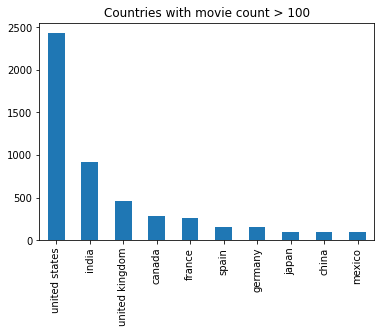

In [ ]:
# Country-dependence of the movies
df_movies = df[df["type"] == "Movie"]
print(df_movies.head(5))

df_movies_country = list(df_movies["country"])
country_counts = {}

# do a counting of the country for each movie title
for movie in df_movies_country:
  for country in movie:
    if country != "":
      if country not in country_counts:
        country_counts[country] = 1
      else:
        country_counts[country] += 1

country_counts = pd.Series(country_counts)
country_counts.sort_values(ascending=False, inplace=True)

print("Major countries broadcasted in Netflix are: \n{}\n".format(country_counts.head(5)))

ax1 = country_counts[country_counts > 100].plot.bar()
ax1.set_title("Countries with movie count > 100")

Thanks to Hollywood the United States has the highest movie counts about 2500, and then it comes India where Bollywood is the engine of movie production. United Kingdom is the third one, but is already half of India and almost 20% of what the USA has produced. 

Then I will also examine the production per year for TV show. 

   show_id  ...                                        description
0       s1  ...  [future, elite, inhabit, island, paradise, far...
5       s6  ...  [genetics, professor, experiments, treatment, ...
11     s12  ...  [dark, thriller, naïve, law, student, detectiv...
12     s13  ...  [archival, video, new, interviews, examine, me...
16     s17  ...  [psychology, professor, faces, alzheimer, daug...

[5 rows x 12 columns]
Major countries broadcasted in Netflix are: 
united states     866
united kingdom    256
japan             184
south korea       157
canada            126
dtype: int64



Text(0, 0.5, 'counts')

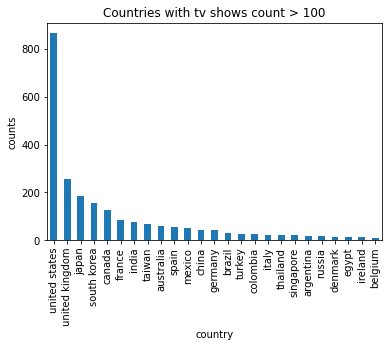

In [ ]:
df_tvshows = df[df["type"] == "TV Show"]
print(df_tvshows.head(5))

df_tvshows_country = list(df_tvshows["country"])
tvshow_country_counts = {}

# do a counting of countries available for each TV title
for tvshow in df_tvshows_country:
  for country in tvshow:
    if country != "":
      if country not in tvshow_country_counts:
        tvshow_country_counts[country] = 1
      else:
        tvshow_country_counts[country] += 1

tvshow_country_counts = pd.Series(tvshow_country_counts)
tvshow_country_counts.sort_values(ascending=False, inplace=True)

print("Major countries broadcasted in Netflix are: \n{}\n".format(tvshow_country_counts.head(5)))

ax2 = tvshow_country_counts[tvshow_country_counts > 10].plot.bar()
ax2.set_title("Countries with tv shows count > 100")
ax2.set_xlabel("country")
ax2.set_ylabel("counts")

The United States have a significantly higher TV shows production above 800 in the record. Then it comes United Kingdom and Japan, where both places are also famous for their TV shows. 

I also want to examine how many movies and TV shows are produced per year. 

type     release_year
Movie    1942              2
         1943              3
         1944              3
         1945              3
         1946              1
                        ... 
TV Show  2017            268
         2018            387
         2019            414
         2020            457
         2021             19
Length: 118, dtype: int64


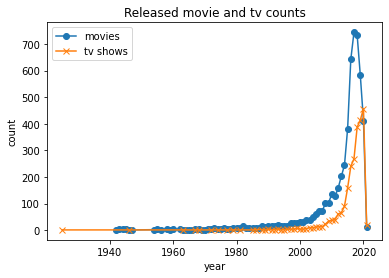

In [ ]:
df_type_sorted = df.groupby(["type", "release_year"]).size()
print(df_type_sorted)

ax3 = df_type_sorted.loc["Movie"].plot(x="release_year", marker="o", label="movies")
ax3.set_xlabel("year")
ax3.set_ylabel("count")

ax4 = df_type_sorted.loc["TV Show"].plot(x="release_year", marker="x", label="tv shows")
ax4.set_title("Released movie and tv counts")
ax4.set_xlabel("year")
ax4.set_ylabel("count")
ax4.legend()


The number of movies available in Netflix is significantly higher for earlier movie before 2018. After that, the number of titles for TV shows exceeds that of movies. This can be attributed to the recent rapid growth of many successful TV shows from different streaming companies. 

Then we also examine the genre classification for movies in the USA. 

Text(0, 0.5, 'counts')

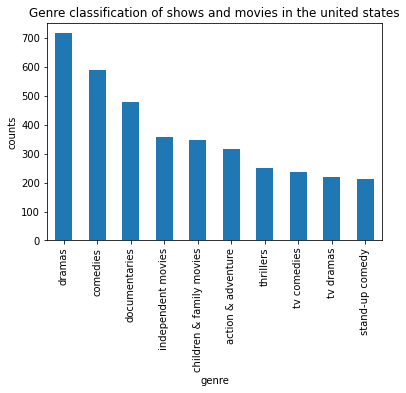

In [ ]:
# genre classification

# I will only study the united states for simplicity
df_countries = list(zip(df["country"], df["listed_in"]))

#print(df_countries[:5])
genre = {"united states":{}}
#print(genre["united states"])

for i in range(len(df_countries)):
  #if i < 15: print(df_countries[i][0])
  if "united states" in df_countries[i][0]:
    for genre_type in df_countries[i][1]:
      if genre_type not in genre["united states"]:
        genre["united states"][genre_type] = 1
      else:
        genre["united states"][genre_type] += 1

genre_united_states = genre["united states"]
genre_united_states = pd.Series(genre_united_states).sort_values(ascending=False).head(10)

ax6 = genre_united_states.plot.bar()

ax6.set_title("Genre classification of shows and movies in the united states")
ax6.set_xlabel("genre")
ax6.set_ylabel("counts")

Due to the high number of TV shows, dramas peak at its number in the classification of Netflix title in the US. After that, comedies and documentaries come to next, where are expected as there are indeed many famous titles for these genre. 

# 2. Network analysis of directors and actors/actresses

After understanding the typical features of titles available in Netflix, I will examine how the production crews are connected with each other in the film production industry. 

I will make heavy use of NetworkX package avilable in python. 

I will first build the graph based on the production cast and director in the list. 

In [ ]:
graph = nx.Graph()

directors_set = set(df["director"])
actors_list_raw = list(df["cast"])

actors_set = set()
for movie in actors_list_raw:
  for actor in movie:
    actors_set.add(actor)

# remove counts for no actor or director
actors_set.remove("")
directors_set.remove("")

print("Number of directors in the catalogue: {}".format(len(directors_set)))
print("Number of actors in the catalogue: {}".format(len(actors_set)))

# add the node in the graph
# first add all director as a node
for director in directors_set:
  graph.add_node(director)

# then add all actor/actress as a mode
for actor in actor_set:
  graph.add_node(actor)

full_cast = list(zip(df["director"], df["cast"]))
full_cast = [cast for cast in full_cast if cast[0] != "" and cast[1] != []]

# now add the vertices according to the (director,cast) pair in the DataFrame
for cast in full_cast:
  for actor in cast[1]:
    graph.add_edge(cast[0], actor)


Number of directors in the catalogue: 4048
Number of actors in the catalogue: 32873


The linear regression of the log deg- log-cnt pair: 
   slope = -2.230037280975392 and intercept = 9.987647675697044


Text(10, 10000, 'log(y) = -2.23 log(x) + 9.99')

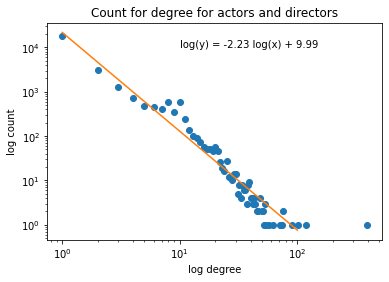

In [ ]:
# arrange the number of degree of each node in descending order
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  
degree_count = collections.Counter(degree_sequence)

deg, cnt = zip(*degree_count.items())

fig5, ax5 = plt.subplots(nrows=1, ncols=1)
ax5.plot(deg, cnt, marker="o", linestyle="None")

ax5.set_title("Count for degree for actors and directors")
ax5.set_yscale("log")
ax5.set_xscale("log")
ax5.set_ylabel("log count")
ax5.set_xlabel("log degree")

# I also calculate their log-log relation to extract the power dependence
log_deg = []
log_cnt = []
for dc in zip(deg, cnt):
  if dc[0] > 0 and dc[1] > 0:
    log_deg.append([log(dc[0])])
    log_cnt.append(log(dc[1]))
    
# do regression for the log-log scale of deg-cnt pair
deg_lin_reg = LinearRegression()
deg_lin_reg.fit(log_deg, log_cnt)

m = deg_lin_reg.coef_[0]
b = deg_lin_reg.intercept_

print("The linear regression of the log deg- log-cnt pair: \n \
  slope = {} and intercept = {}".format(m, b))

# manually build a line based on the regression
x_lin_reg = [10**i for i in range(3)]
y_lin_reg = [exp(b) * x**m for x in x_lin_reg]

ax5.plot(x_lin_reg, y_lin_reg)
ax5.annotate("log(y) = {:.3} log(x) + {:.3}".format(m,b), xy=(10,10000))

The number of degree for each director/actor/actress can be roughly fits as a power relation count ~ degree^-2.2, this is consistent with the social studies that human connection is more enhanced based on their original number of connection. The data shows a general range from 1 (individual) to about 100. There is an outlier with a connection about 500. A peak can be seen about 10 degree, which is the typical number of cast in a standard TV show and movie.

Then I will examine who is the more influencing figures in this network. 

In [ ]:
# fundamental properties of the graph

print("Fundamental properties of the graph:")
print("Number of nodes: {}".format(len(graph.nodes())))
print("Number of edges: {}".format(len(graph.edges())))
print(" ")

print("Is the graph fully-connected? {}".format(nx.is_connected(graph)))
print("Number of connected components {}".format(nx.number_connected_components(graph)))
print(" ")

# study the centrality of the network
centrality = nx.degree_centrality(graph)
centrality = list(centrality.items())

centrality.sort(key=lambda x: x[1], reverse=True)
centrality.pop(0)

print("Degree of centrality: \n Person  Value")
for i in range(15):
  print("{}".format(centrality[i]))


Fundamental properties of the graph:
Number of nodes: 36556
Number of edges: 37540
 
Is the graph fully-connected? False
Number of connected components 9705
 
Degree of centrality: 
 Person  Value
('martin scorsese', 0.003255368622623444)
('steven spielberg', 0.002762959923403091)
('cathy garcia-molina', 0.0024620434961017644)
('kunle afolayan', 0.0020790589522637123)
('youssef chahine', 0.0020790589522637123)
('robert rodriguez', 0.0020243468745725617)
('quentin tarantino', 0.0019696347968814116)
('mcg', 0.0019422787580358363)
('noah baumbach', 0.00169607440842566)
('david dhawan', 0.0015866502530433593)
('clint eastwood', 0.0014772260976610586)
('anurag kashyap', 0.0014498700588154835)
('don michael paul', 0.0014498700588154835)
('david fincher', 0.0014498700588154835)
('yılmaz erdoğan', 0.0014225140199699083)


As expected, the central figure in the movie and TV shows in the catalogue of Netflix are some of the well known person, including Martix Scorses, Steven Spielberg, Quentin Tarantino. Their large number of participation in various movies allow them to build an extended network in the casting crew. 

Then I will examine some of the microscopic feature in the network. 

Fundamental properties of the largest fully-connected subgraph:
Number of nodes: 48
Number of edges: 49
 
Radius of the graph : 4
Perimeter of the graph : 8
Eccentricity of the graph : {'mohamed morshed': 6, 'meera ali': 6, 'ahmed saif': 6, 's.a. zaidi': 7, 'althogali saif': 8, 'pascale matar': 8, 'nawal chamoun': 6, 'mohammad abu diak': 8, 'am rashed': 6, 'maria khan': 8, 'zayed mohammed mahmoud': 8, 'nasser al-dhahnani': 6, 'saad abdullah': 8, 'abdullah al hamiri': 6, 'hani al-shaibani': 7, 'khaled al-nuaimi': 4, 'luke coutts': 8, 'ammar rahma': 8, 'abdullah bin heider': 8, 'ahmed zain': 5, 'alzaabi matar': 8, 'iman husein': 6, 'tariq almuhairi': 6, 'abeer mohammed': 8, 'hani abd al ghani': 8, 'khaled abdullah': 8, 'muhammed murshed': 4, 'ahmed zein': 5, 'alhamadi hamad': 8, 'huda al ghanim': 6, 'yaser alneyadi': 4, 'alia almannai': 6, 'ana druzhynina': 8, 'abdullah al-ramsi': 6, 'aisha al suwaidi': 6, 'salama almazrouei': 6, 'amal mohammed': 6, 'alaa shakir': 8, 'ibrahim almeirasi':

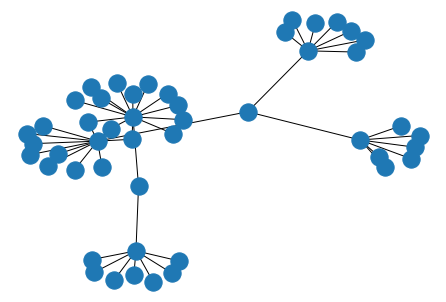

In [ ]:
# let us analyze the largest subgroup 

subgraphs = sorted(nx.connected_components(graph), key=lambda x:len(x), reverse=True)
largest_subgraph = graph.subgraph(subgraphs[1]).copy()

print("Fundamental properties of the second largest fully-connected subgraph:")
print("Number of nodes: {}".format(len(largest_subgraph.nodes())))
print("Number of edges: {}".format(len(largest_subgraph.edges())))
print(" ")

# this part takes a long time for a very large subgraph, so do the second largest one
print("Radius of the graph : {}".format(nx.algorithms.distance_measures.radius(largest_subgraph)))
print("Perimeter of the graph : {}".format(nx.algorithms.distance_measures.diameter(largest_subgraph)))
print("Eccentricity of the graph : {}".format(nx.algorithms.distance_measures.eccentricity(largest_subgraph)))
print("Center of the graph : {}".format(nx.algorithms.distance_measures.center(largest_subgraph)))
print(" ")

nx.draw(largest_subgraph, with_labels=False)

The non-fully-connected struture of the network suggested that the common "six-degree" connection where every node can be connected . This suggests that the small-world theory does not fully applied in this system, but to only a very good approximation, as the first fully-connected group occupies to almost 90% of the actors and directors in the industry. 

The second fully-connected one is almost 3 orders of magnitude small, which is another director, acting groups in the Arabia region. 

# 3. Context Analysis of titles in Netflix

I will carry out a semantic analysis for the description of each title, so that we can build a network to understand how movies are related to each other. In the process, I will tokenize the description and use the sklean module to calculate their tf-idf vector. I use the vector as an indicator of their content, and compute the similarity score among different titles. The highest score will indicate that that particular movie/TV show title has the most similar content to the one we compare with. 

In [34]:
# build the vectorizer and transformer for the title description
transformer = TfidfTransformer()
vectorizer = CountVectorizer()

corpus = list(df["description"])
for i, sent in enumerate(corpus):
  corpus[i] = " ".join(sent)

X = vectorizer.fit_transform(corpus)
transformer.fit(X)


TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [35]:
print("Size of the vocabulary: {}" .format(len(vectorizer.vocabulary_)))

print("X shape = {}".format(X.shape))

Size of the vocabulary: 17405
X shape = (7787, 17405)


In [74]:
# build the tf-idf matrix for all the title descsription
X2 = transformer.transform(X)
print("X2 shape = {}".format(X2.shape))

# some random output
print("\n Some random output from X2[0]")

print("{}".format(X2[0]))

X2 shape = (7787, 17405)

 Some random output from X2[0]
  (0, 14603)	0.36304841405586685
  (0, 14228)	0.3041251822331982
  (0, 13443)	0.3041251822331982
  (0, 11089)	0.2897193195344405
  (0, 10748)	0.16848893778468682
  (0, 8206)	0.22607040610522364
  (0, 8021)	0.2318136946582803
  (0, 7760)	0.33589391250235534
  (0, 6375)	0.1865483388174808
  (0, 6188)	0.21263531751448708
  (0, 5525)	0.256958747308016
  (0, 4852)	0.22980424575450453
  (0, 3540)	0.3271521155496175
  (0, 2474)	0.21756675982344661


Then I calculate the cosine-similairity for all the vector pairs. 

In [91]:
# compute the cosine similiarity pair for all titles
# then filter the ones with the highest scores

cs = cosine_similarity(X2)
print(cs.shape)

(7787, 7787)


In [103]:
df[df["title"] == "Ghost Rider"]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2399,s2400,Movie,Ghost Rider,mark steven johnson,"[nicolas cage, eva mendes, wes bentley, sam el...","[united states, australia]","October 1, 2020",2007,PG-13,110 min,"[action & adventure, sci-fi & fantasy]","[selling, soul, save, loved, one, daredevil, b..."


I wrote a small subroutine so that by giving the movie title, it will find the 5 highest scores based on cosine similarity, and then it will give a pretty output to let the readers select the movies. 

In [124]:
def recommend_titles(movie_title):

  movie_id = df[df["title"] == movie_title].index[0]
  print("Found movie ID = {}".format(movie_id))

  score_gr = cs[movie_id, :]
  n_titles = score_gr.shape[0]

  movie_recommendations = [[0, 0, None, None] for i in range(10)]

  score_gr_sorted = sorted(score_gr, reverse=True)
  print("number of titltes = {}".format(n_titles))

  for i in range(10):
    movie_recommendations[i][0] = np.where(score_gr == score_gr_sorted[i])[0][0]
    movie_recommendations[i][1] = df["title"].iloc[movie_recommendations[i][0]]
    movie_recommendations[i][2] = score_gr[movie_recommendations[i][0]]
    movie_recommendations[i][3] = df["description"].iloc[movie_recommendations[i][0]]

  print("original movie")
  print(movie_recommendations[0][1], movie_recommendations[0][3])

  print("\n-----Recommendation List of Best 5-----")
  for i in range(1,6):
    print(movie_recommendations[i][1], movie_recommendations[i][3])

Here are some examples where I use the movie titles with Edward Norton as one of the acting crew.

In [126]:
recommend_titles("Primal Fear")

Found movie ID = 4969
number of titltes = 7787
original movie
Primal Fear ['altar', 'boy', 'found', 'running', 'murder', 'scene', 'conviction', 'seems', 'certain', 'attorney', 'determined', 'win', 'case']

-----Recommendation List of Best 5-----
Shadow of Truth ['documentary', 'series', 'explores', 'explosive', 'murder', 'case', 'israeli', 'girl', 'subsequent', 'conviction', 'ukrainian', 'immigrant']
The Good Detective ['doubts', 'rise', 'murder', 'conviction', 'veteran', 'detective', 'partners', 'young', 'hotshot', 'hunt', 'case', 'hidden', 'truths']
Duniya ['lawyer', 'defends', 'childhood', 'friend', 'girlfriend', 'brother', 'murder', 'case', 'unaware', 'deep', 'connection', 'attorney']
Ahista Ahista ['stood', 'groom', 'altar', 'young', 'woman', 'finds', 'help', 'healing', 'another', 'man', 'returns', 'hoping', 'win', 'back']
How to Get Away with Murder ['brilliant', 'criminal', 'defense', 'attorney', 'law', 'professor', 'annalise', 'keating', 'plus', 'five', 'students', 'become', 'i

In [127]:
recommend_titles("American History X")

Found movie ID = 466
number of titltes = 7787
original movie
American History X ['gets', 'sent', 'prison', 'murder', 'comes', 'changed', 'man', 'prevent', 'younger', 'brother', 'following', 'footsteps']

-----Recommendation List of Best 5-----
Fukrey Boyzzz: Space Mein Fukrapanti ['foreboding', 'dream', 'aliens', 'comes', 'true', 'trio', 'must', 'prevent', 'human', 'intelligence', 'stolen', 'planet', 'earth']
Divines ['shrewd', 'teenager', 'wisecracking', 'best', 'friend', 'plan', 'get', 'rich', 'die', 'trying', 'following', 'footsteps', 'flashy', 'female', 'drug', 'dealer']
The First Wives Club ['following', 'friend', 'suicide', 'husband', 'dumps', 'younger', 'model', 'three', 'women', 'plot', 'payback', 'exes']
Good Time ['spearheading', 'bank', 'robbery', 'man', 'must', 'get', 'mentally', 'challenged', 'younger', 'brother', 'jail', 'eluding', 'capture']
Kuppivala ['young', 'woman', 'talented', 'traditional', 'dance', 'finds', 'life', 'changed', 'love', 'man', 'clashes', 'wishes', 'f

In [128]:
recommend_titles("The Guardian Brothers")

Found movie ID = 6427
number of titltes = 7787
original movie
The Guardian Brothers ['chinese', 'family', 'soup', 'shop', 'targeted', 'sabotage', 'competitor', 'two', 'guardians', 'spirit', 'world', 'leave', 'retirement', 'protect']

-----Recommendation List of Best 5-----
Check The Store Next Door: The Next Chapter ['former', 'shop', 'owner', 'grows', 'bored', 'retirement', 'buys', 'fish', 'pond', 'manages', 'new', 'hijinks', 'life', 'staff', 'quirky', 'employees']
The Outsider ['frontier', 'sheriff', 'tries', 'protect', 'sadistic', 'son', 'chinese', 'railroad', 'worker', 'hellbent', 'revenge']
The Bare-Footed Kid ['working', 'family', 'friend', 'business', 'penniless', 'orphan', 'draws', 'attention', 'corrupt', 'competitor', 'torn', 'divided', 'loyalties']
Famous in Ahmedabad ['follow', 'boy', 'goes', 'ordinary', 'child', 'colorful', 'competitor', 'quest', 'big', 'win', 'india', 'biggest', 'festival']
All In My Family ['starting', 'family', 'america', 'gay', 'filmmaker', 'documents',

The general recommendation does not fully fit what the original titles supposed to be. However, by examining the key words in the description, indeed we can find similar words being used in the description. This is why the tf-idf formalism will suggest these movies are similar to the original title. 